In [1]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [2]:
class FC:

    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.W = initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = initializer.B(self.n_nodes2)
        self.optimizer = optimizer
        self.HW = 0
        self.HB = 0

    def forward(self, X):
        self.Z = X
        self.A = X @ self.W + self.B
        return self.A

    def backward(self, dA):
        self.dB = np.sum(dA, axis=0)
        self.dW = self.Z.T @ dA
        self.dZ = dA @ self.W.T
        self = self.optimizer.update(self)

         # Update weights and biases using the optimizer
        #self.W, self.B = self.optimizer.update(self.W, self.B, self.dW, self.dB)

        return self.dZ

In [3]:
class SimpleInitializer:

    def __init__(self, sigma):
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W

    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

In [4]:
class SGD:

    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        layer.W -= self.lr * layer.dW / len(layer.Z)
        layer.B -= self.lr * layer.dB / len(layer.Z)
        return layer
    def train(x_train, y_train, x_val, y_val, epochs, batch_size, lr):
        input_size = x_train.shape[1]
        output_size = y_train.shape[1]

In [5]:
class Sigmoid:

    def forward(self, A):
        self.A = A
        Z = 1 / (1 + np.exp(-self.A))
        return Z

    def backward(self, dZ):
        dA = dZ * ((1 / (1 + np.exp(-self.A))) - (1 / (1 + np.exp(-self.A)))**2)
        return dA

In [6]:
class Tanh:

    def forward(self, A):
        self.A = A
        Z = np.tanh(self.A)
        return Z

    def backward(self, dZ):
        dA = dZ * (1 - np.tanh(self.A)**2)
        return dA

In [7]:
class softmax:

    def forward(self, A):
        Z = np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
        return Z

    def backward(self, Z, y):
        dA = Z - y
        loss = - np.sum(y * np.log(Z)) / len(y)
        return dA, loss

In [8]:
class ReLU:

    def forward(self, A):
        self.A = A
        Z = np.maximum(0, A)
        return Z

    def backward(self, dZ):
        dA = dZ * np.where(self.A > 0, 1, 0)
        return dA

In [9]:
class XavierInitializer:

    def __init__(self, sigma):
        _ = sigma

    def W(self, n_nodes1, n_nodes2):
        self.sigma = 1 / np.sqrt(n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W

    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

In [10]:
class HeInitializer:

    def __init__(self, sigma):
        _ = sigma

    def W(self, n_nodes1, n_nodes2):
        self.sigma = np.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W

    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

In [11]:
class AdaGrad:

    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        layer.HW += layer.dW * layer.dW
        layer.HB += layer.dB * layer.dB
        delta = 1e-7
        layer.W -= self.lr * layer.dW / (np.sqrt(layer.HW) + delta) / len(layer.Z)
        layer.B -= self.lr * layer.dB / (np.sqrt(layer.HB) + delta) / len(layer.Z)
        return layer

In [12]:
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int64)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [13]:
class ScratchDeepNeuralNetrowkClassifier():

    def __init__(self, verbose=False, epoch=1, optimizer=SGD, initializer=HeInitializer, activater=ReLU):
        self.verbose = verbose
        self.batch_size = 20
        self.n_features = 784
        self.n_nodes1 = 400
        self.n_nodes2 = 200
        self.n_output = 10
        self.sigma = 0.02
        self.lr = 0.5
        self.epoch = epoch
        self.optimizer = optimizer
        self.initializer = initializer
        self.activater = activater

    def fit(self, X, y, X_val=None, y_val=None):
        self.loss_train = []
        self.loss_val = []
        optimizer = self.optimizer(self.lr)
        self.FC1 = FC(self.n_features, self.n_nodes1, self.initializer(self.sigma), optimizer)
        self.activation1 = self.activater()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, self.initializer(self.sigma), optimizer)
        self.activation2 = self.activater()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.initializer(self.sigma), optimizer)
        self.activation3 = softmax()

        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)
            for mini_X, mini_y in get_mini_batch:
                A1 = self.FC1.forward(mini_X)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                #print(Z2.shape)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                dA3, loss = self.activation3.backward(Z3, mini_y)
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1)

            if self.verbose:
                A1 = self.FC1.forward(X)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                self.loss_train.append(self.activation3.backward(Z3, y)[1])

                if X_val is not None:
                    A1 = self.FC1.forward(X_val)
                    Z1 = self.activation1.forward(A1)
                    A2 = self.FC2.forward(Z1)
                    Z2 = self.activation2.forward(A2)
                    A3 = self.FC3.forward(Z2)
                    Z3 = self.activation3.forward(A3)
                    self.loss_val.append(self.activation3.backward(Z3, y_val)[1])

    def predict(self, X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return np.argmax(Z3, axis=1)

In [14]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
X_train /= 255
X_test /= 255

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [16]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_val[:, np.newaxis])

C:\Users\DoBUY\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [17]:
SDNN = ScratchDeepNeuralNetrowkClassifier(verbose=True, epoch=10, optimizer=AdaGrad, initializer=HeInitializer, activater=ReLU)

SDNN.fit(X_train, y_train_one_hot, X_val, y_test_one_hot)

In [18]:
pred = SDNN.predict(X_val)
accuracy_score(y_val, pred)

0.981

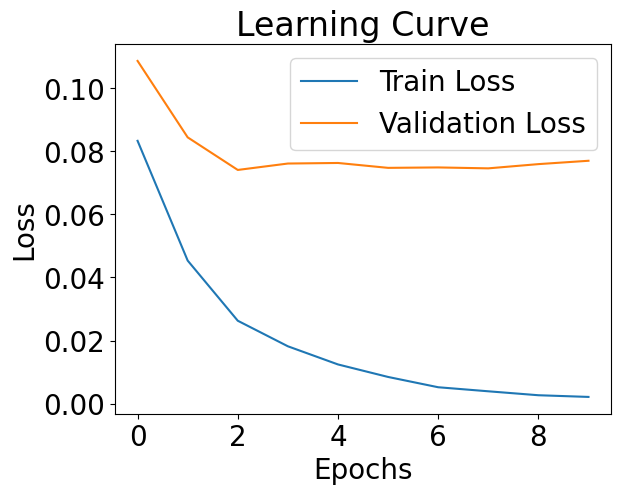

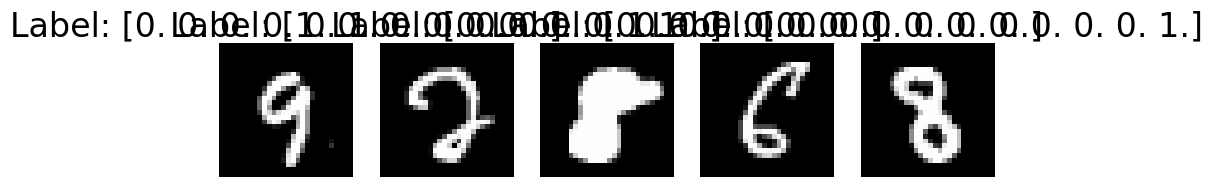

In [27]:
# Learning Curve Plot
plt.plot(SDNN.loss_train, label='Train Loss')
plt.plot(SDNN.loss_val, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Display MNIST Images
def display_mnist_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off')
    plt.show()

display_mnist_images(X_train.reshape(-1, 28, 28), y_train, num_images=5)